In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ga-customer-revenue-prediction/sample_submission.csv
/kaggle/input/ga-customer-revenue-prediction/train_v2.csv
/kaggle/input/ga-customer-revenue-prediction/test_v2.csv
/kaggle/input/ga-customer-revenue-prediction/sample_submission_v2.csv
/kaggle/input/ga-customer-revenue-prediction/train.csv
/kaggle/input/ga-customer-revenue-prediction/test.csv


In [2]:
import json
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import joblib


def load_df(csv_path='/kaggle/input/ga-customer-revenue-prediction/train_v2.csv', nrows=None):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']

    df = pd.read_csv(csv_path,
                     converters={column: json.loads for column in JSON_COLUMNS},
                     dtype={'fullVisitorId': 'str'},
                     nrows=nrows)

    for column in JSON_COLUMNS:
        column_as_df = pd.json_normalize(df[column])
        column_as_df.columns = [f"{column}_{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)

    df.drop(columns=['customDimensions', 'hits'], inplace=True)

    df = df.fillna({'totals_pageviews':0,
                    'totals_transactionRevenue':0,
                    'totals_pageviews':0})

    df['device_isMobile'] = df['device_isMobile'].astype(int)
    df['totals_transactionRevenue'] = df['totals_transactionRevenue'].astype(int)

    cat_col = df.select_dtypes(include='object').columns

    df[cat_col] = df[cat_col].astype(str)

    return df


df = load_df('/kaggle/input/ga-customer-revenue-prediction/train_v2.csv', nrows=100_000)

In [3]:
y = df['totals_transactionRevenue']
X = df.drop(columns='totals_transactionRevenue')

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=42)

In [5]:
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

In [6]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

In [7]:
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [8]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [9]:
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

In [10]:
param_grid = {
    'num_leaves': [31, 50],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200]
}

lgb_model = lgb.LGBMRegressor()

grid_search = GridSearchCV(estimator=lgb_model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search.fit(X_train_preprocessed, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031938 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3011
[LightGBM] [Info] Number of data points in the train set: 53333, number of used features: 1180
[LightGBM] [Info] Start training from score 1237914.795867
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

GridSearchCV(cv=3, estimator=LGBMRegressor(),
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'n_estimators': [100, 200], 'num_leaves': [31, 50]},
             scoring='neg_mean_squared_error')

In [11]:
best_model = grid_search.best_estimator_

In [12]:
y_train_pred = best_model.predict(X_train_preprocessed)
y_test_pred = best_model.predict(X_test_preprocessed)

In [13]:
def get_metrics(y_true, y_pred):
    return {
        "MSE": mean_squared_error(y_true, y_pred),
        "R2": r2_score(y_true, y_pred)
    }

In [14]:
train_metrics = get_metrics(y_train, y_train_pred)
test_metrics = get_metrics(y_test, y_test_pred)
print("Train metrics:", train_metrics)
print("Test metrics:", test_metrics)

Train metrics: {'MSE': 606668727239132.9, 'R2': 0.3349906821362776}
Test metrics: {'MSE': 276773111534361.66, 'R2': 0.28692387320013324}


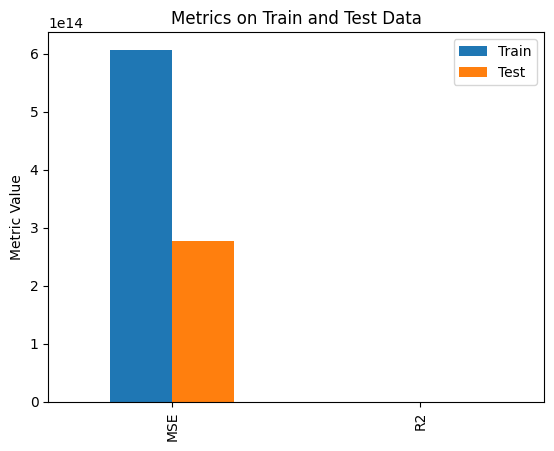

In [15]:
metrics_df = pd.DataFrame({'Train': list(train_metrics.values()), 'Test': list(test_metrics.values())}, index=train_metrics.keys())
metrics_df.plot(kind='bar')
plt.title("Metrics on Train and Test Data")
plt.ylabel("Metric Value")
plt.show()

In [16]:
feature_importance = best_model.feature_importances_
feature_names = numeric_features.tolist() + preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features).tolist()

importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print(importance_df.head(10))

                                  Feature  Importance
1                                 visitId        1884
0                                    date         950
2                             visitNumber         935
73291    device_operatingSystem_Macintosh         315
74130  geoNetwork_networkDomain_(not set)         269
83792  totals_totalTransactionRevenue_nan         200
73564        geoNetwork_region_California         148
11               channelGrouping_Referral         136
85202     trafficSource_isTrueDirect_True         126
7                  channelGrouping_Direct         116


/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 3585 (\N{THAI CHARACTER KO KAI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 3641 (\N{THAI CHARACTER SARA UU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 3648 (\N{THAI CHARACTER SARA E}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 3636 (\N{THAI CHARACTER SARA I}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 3657 (\N{THAI CHARACTER MAI THO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.10/site-pa

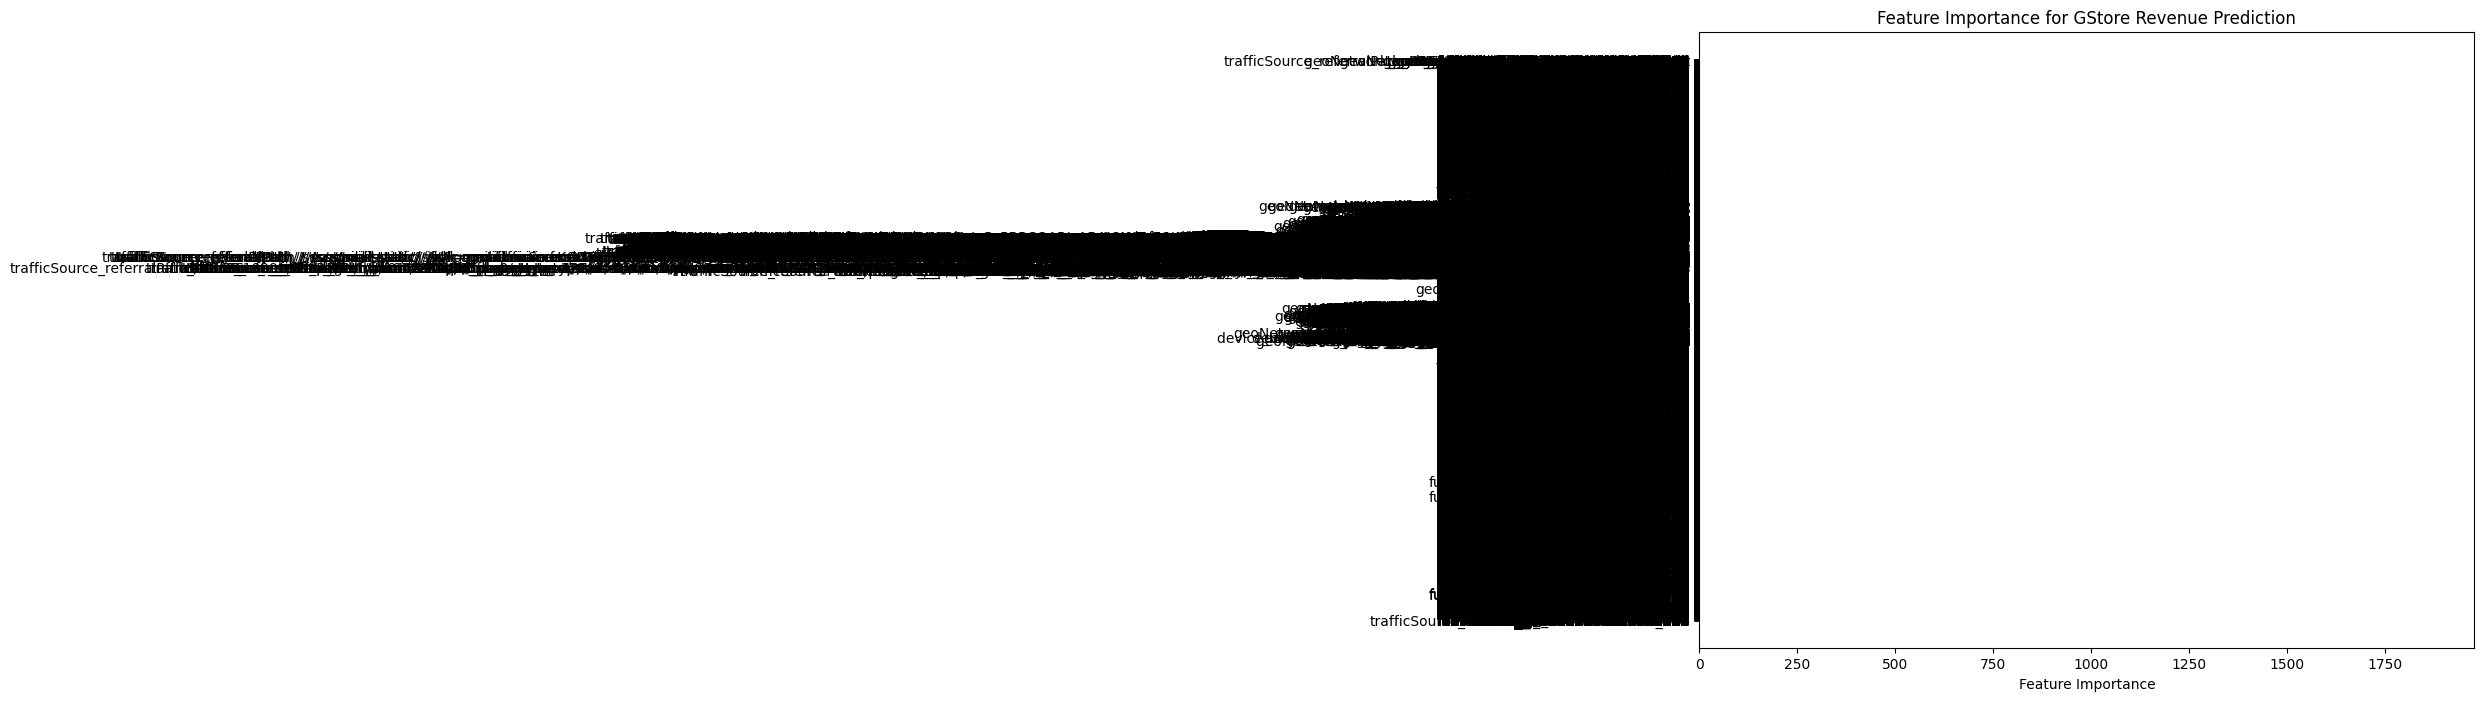

In [17]:
plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel("Feature Importance")
plt.title("Feature Importance for GStore Revenue Prediction")
plt.gca().invert_yaxis()
plt.show()

In [18]:
final_model = Pipeline(steps=[('preprocessor', preprocessor),
                              ('regressor', best_model)])

joblib.dump(final_model, 'gstore_revenue_model.pkl')

['gstore_revenue_model.pkl']

In [19]:
loaded_model = joblib.load('gstore_revenue_model.pkl')

In [20]:
example_data = X_test.iloc[:5, :]
example_pred = loaded_model.predict(example_data)

print("Predictions:", example_pred)
print("Actual revenues:", y_test.iloc[:5].values)

Predictions: [166608.24824375 166608.24824375 166608.24824375 166608.24824375
 166608.24824375]
Actual revenues: [0 0 0 0 0]
